# Evolver Loop 1 Analysis

Analysis of baseline results and data patterns to inform next steps.

**Goal**: Understand why baseline scored 0.4589 and identify high-impact improvements to reach gold (<0.1119).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load Data and Baseline Predictions

In [2]:
# Load training data and baseline predictions
train_df = pd.read_csv('/home/data/train.csv')
test_df = pd.read_csv('/home/data/test.csv')

# Load baseline predictions (from the experiment)
# For now, let's analyze the data structure and patterns

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")

# Basic statistics
print(f"\nTarget (pressure) statistics:")
print(train_df['pressure'].describe())

# Check R and C distributions (lung attributes)
print(f"\nR (resistance) distribution:")
print(train_df['R'].value_counts().sort_index())

print(f"\nC (compliance) distribution:")
print(train_df['C'].value_counts().sort_index())

Training data shape: (5432400, 8)
Test data shape: (603600, 7)

Columns: ['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure']

Target (pressure) statistics:


count    5.432400e+06
mean     1.121807e+01
std      8.106474e+00
min     -1.895744e+00
25%      6.329607e+00
50%      7.032628e+00
75%      1.364103e+01
max      6.482099e+01
Name: pressure, dtype: float64

R (resistance) distribution:
R
5     1791200
20    1474080
50    2167120
Name: count, dtype: int64

C (compliance) distribution:
C
10    2017520
20    1640160
50    1774720
Name: count, dtype: int64


## Analyze Breath Patterns

Understanding how pressure evolves within a breath is crucial for this simulation problem.

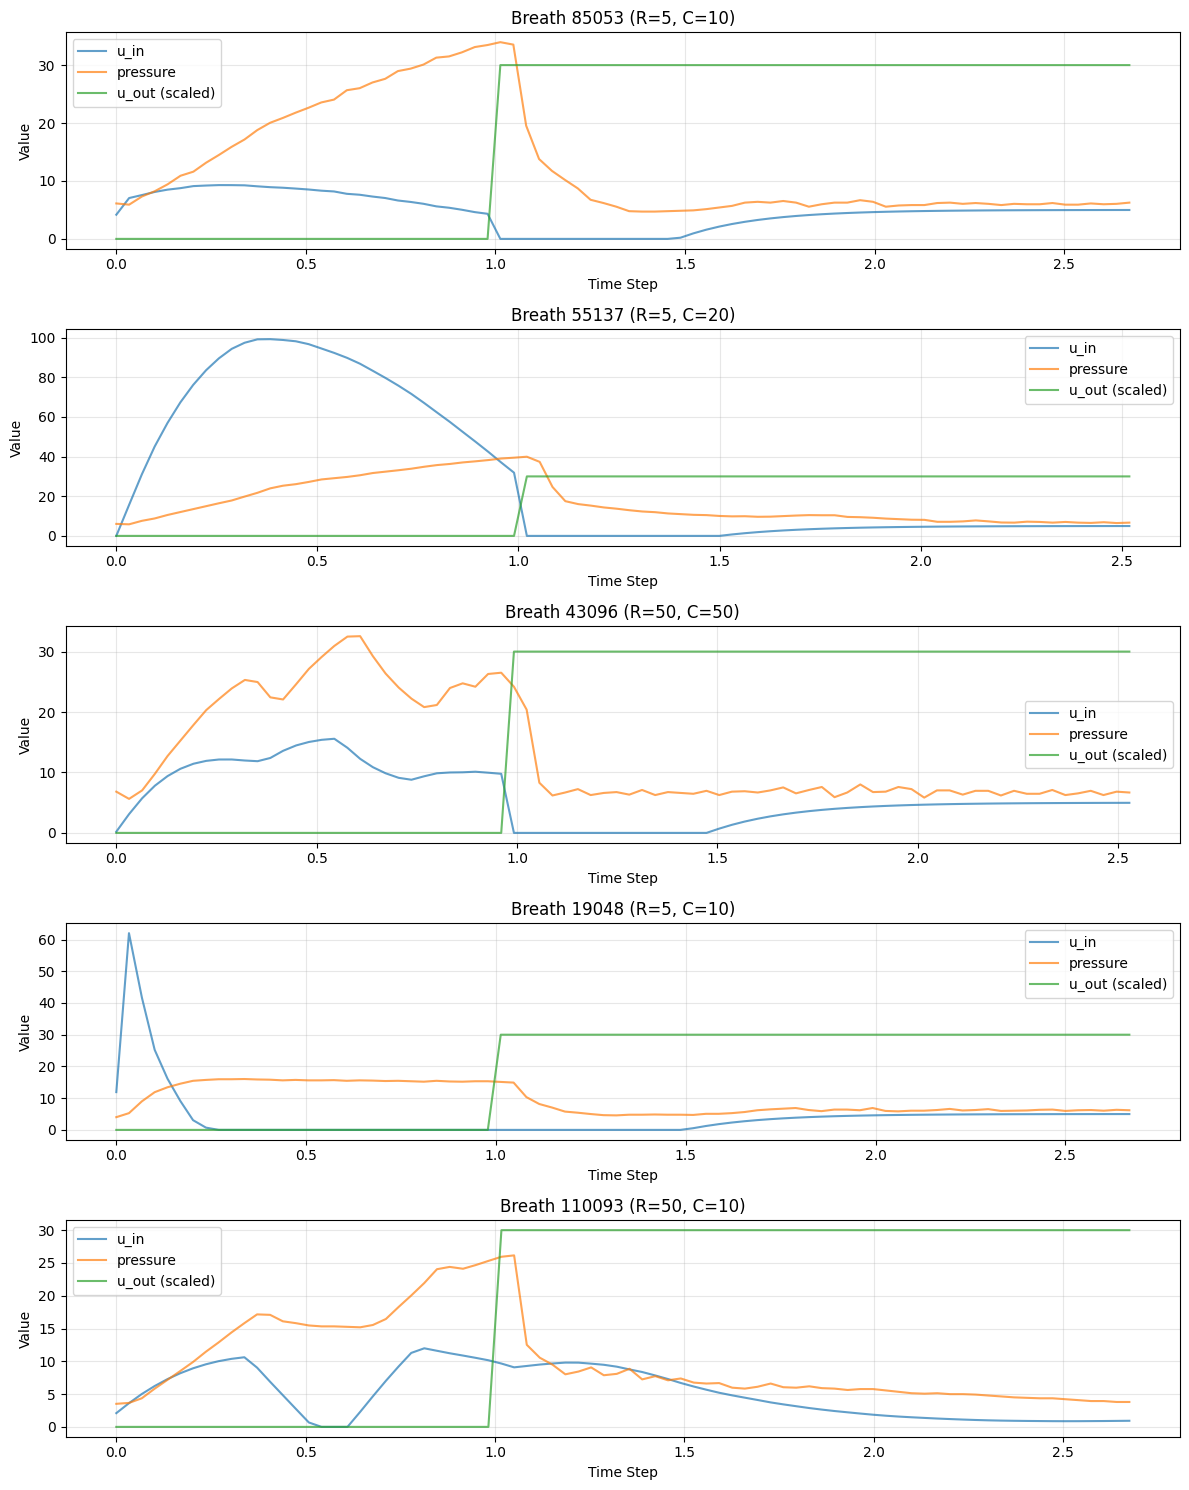

In [3]:
# Look at a few example breaths to understand the pattern
sample_breaths = train_df['breath_id'].unique()[:5]

fig, axes = plt.subplots(5, 1, figsize=(12, 15))
for i, breath_id in enumerate(sample_breaths):
    breath_data = train_df[train_df['breath_id'] == breath_id]
    
    # Plot u_in, u_out, and pressure
    axes[i].plot(breath_data['time_step'], breath_data['u_in'], label='u_in', alpha=0.7)
    axes[i].plot(breath_data['time_step'], breath_data['pressure'], label='pressure', alpha=0.7)
    axes[i].plot(breath_data['time_step'], breath_data['u_out'] * 30, label='u_out (scaled)', alpha=0.7)
    
    axes[i].set_title(f'Breath {breath_id} (R={breath_data["R"].iloc[0]}, C={breath_data["C"].iloc[0]})')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key observation: u_out indicates expiratory phase (when it's 1)
# The competition only scores the inspiratory phase (u_out = 0)

## Analyze R and C Impact

R (resistance) and C (compliance) are lung attributes that should affect pressure dynamics.

R values: [5, 20, 50]
C values: [10, 20, 50]


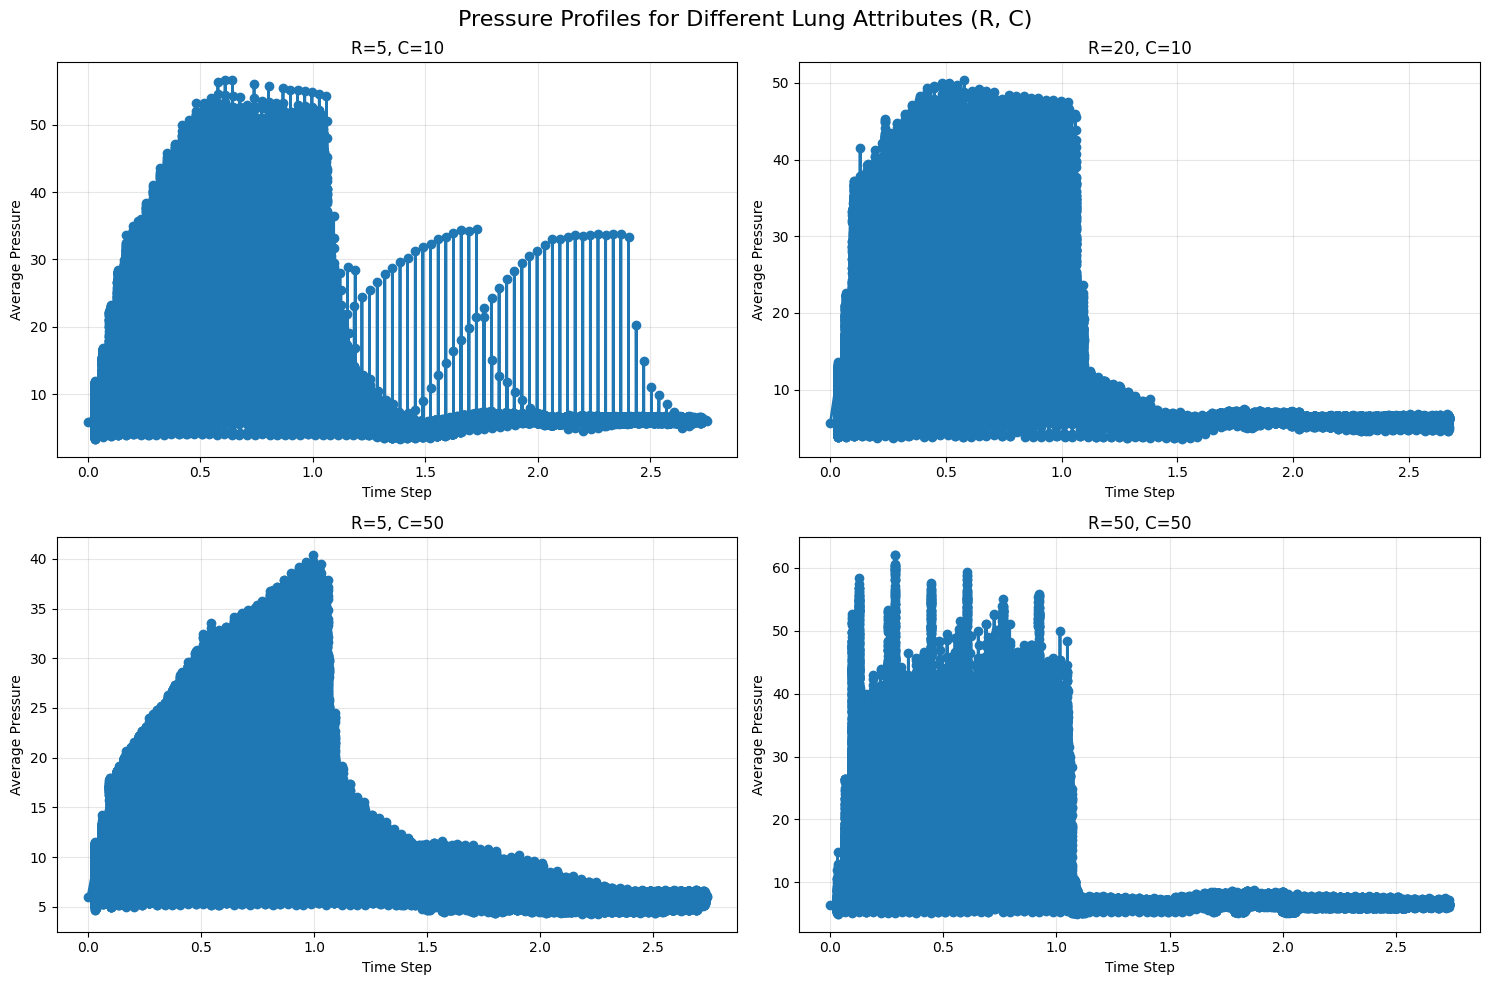


Correlation analysis:
R vs pressure: 0.0160


C vs pressure: -0.0376
R*C vs pressure: 0.0059


In [4]:
# Analyze how R and C affect pressure patterns
# Group by R and C to see average pressure profiles

# Sample a few R,C combinations
r_values = sorted(train_df['R'].unique())
c_values = sorted(train_df['C'].unique())

print(f"R values: {r_values}")
print(f"C values: {c_values}")

# Calculate average pressure for each R,C combination at different time steps
pressure_profiles = train_df.groupby(['R', 'C', 'time_step'])['pressure'].mean().reset_index()

# Plot pressure profiles for different R,C combinations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

combinations = [(5, 10), (20, 10), (5, 50), (50, 50)]  # Low/high R and C

for i, (r, c) in enumerate(combinations):
    profile = pressure_profiles[(pressure_profiles['R'] == r) & (pressure_profiles['C'] == c)]
    if not profile.empty:
        axes[i].plot(profile['time_step'], profile['pressure'], marker='o', linewidth=2)
        axes[i].set_title(f'R={r}, C={c}')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Average Pressure')
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Pressure Profiles for Different Lung Attributes (R, C)', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate correlation between R, C and pressure
print(f"\nCorrelation analysis:")
print(f"R vs pressure: {train_df['R'].corr(train_df['pressure']):.4f}")
print(f"C vs pressure: {train_df['C'].corr(train_df['pressure']):.4f}")
print(f"R*C vs pressure: {(train_df['R'] * train_df['C']).corr(train_df['pressure']):.4f}")

## Analyze Time Series Characteristics

Understanding the temporal dynamics is key for improving predictions.

In [5]:
# Analyze the relationship between u_in and pressure
# This is a control system - u_in is the input that should affect pressure

# Calculate correlation between u_in and pressure at different lags
print("Correlation between u_in and pressure at different lags:")
for lag in [0, 1, 2, 3, 5, 10]:
    if lag == 0:
        corr = train_df['u_in'].corr(train_df['pressure'])
    else:
        # Create lagged u_in
        train_df[f'u_in_lag_{lag}'] = train_df.groupby('breath_id')['u_in'].shift(lag)
        corr = train_df[f'u_in_lag_{lag}'].corr(train_df['pressure'])
        # Clean up
        train_df.drop(columns=[f'u_in_lag_{lag}'], inplace=True)
    
    print(f"  Lag {lag}: {corr:.4f}")

# Analyze the system dynamics - how quickly does pressure respond to u_in changes?
# Look at the first few time steps of each breath
first_steps = train_df.groupby('breath_id').head(10)

print(f"\nPressure progression in first 10 steps (averaged across all breaths):")
progression = first_steps.groupby('time_step').agg({
    'pressure': ['mean', 'std'],
    'u_in': ['mean', 'std']
}).round(4)

print(progression)

Correlation between u_in and pressure at different lags:


  Lag 0: 0.3078


  Lag 1: 0.4083


  Lag 2: 0.4933


  Lag 3: 0.4854


  Lag 5: 0.4995


  Lag 10: 0.5470



Pressure progression in first 10 steps (averaged across all breaths):
          pressure             u_in         
              mean     std     mean      std
time_step                                   
0.000000    5.8116  1.0168  13.9028  25.1065
0.031460    6.0484     NaN   0.0000      NaN
0.031484    5.1345     NaN  19.8479      NaN
0.031518    5.4860     NaN  13.2623      NaN
0.031518    6.4702     NaN  31.1062      NaN
...            ...     ...      ...      ...
0.407418   24.7488     NaN   0.0000      NaN
0.408285   20.8118     NaN  56.7744      NaN
0.439074   23.2021     NaN   0.0000      NaN
0.470712   22.9209     NaN   0.0000      NaN
0.497766   17.2967     NaN  13.6924      NaN

[246835 rows x 4 columns]


## Identify Key Challenges

Based on the analysis, what are the main challenges in predicting pressure?

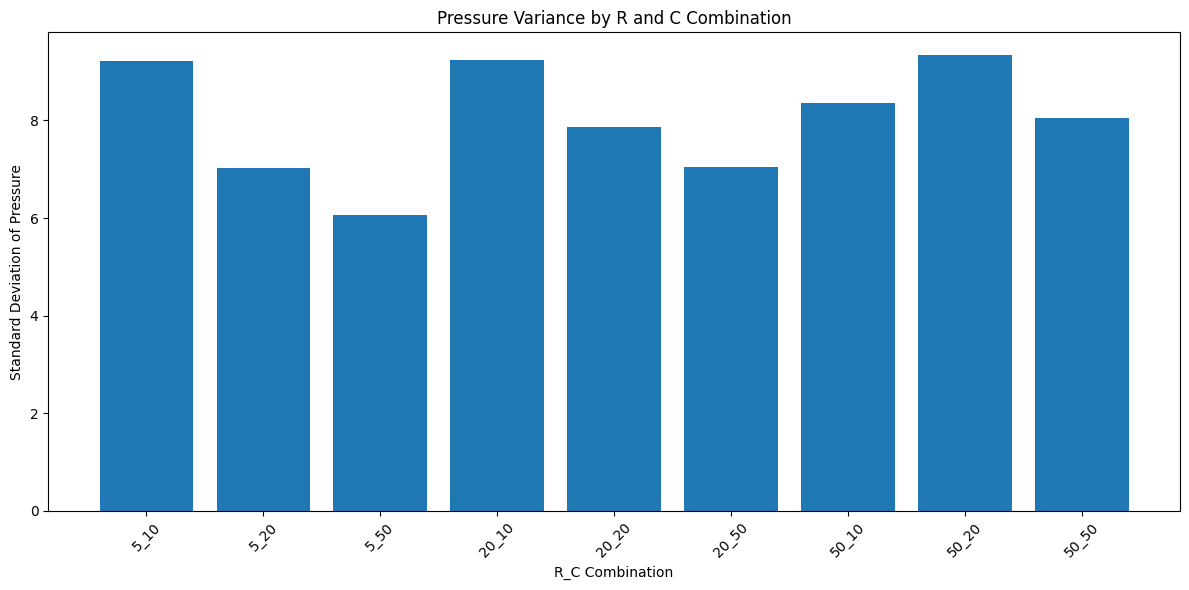

Pressure variance by R,C (higher = harder to predict):
    R   C  pressure    R_C
7  50  20  9.338191  50_20
3  20  10  9.240453  20_10
0   5  10  9.214151   5_10
6  50  10  8.361548  50_10
8  50  50  8.053741  50_50
4  20  20  7.860231  20_20
5  20  50  7.042826  20_50
1   5  20  7.019713   5_20
2   5  50  6.064347   5_50



Inspiratory phase samples: 2061922 (38.0%)
Expiratory phase samples: 3370478 (62.0%)

Pressure statistics:
Inspiratory - Mean: 17.59, Std: 9.24
Expiratory - Mean: 7.32, Std: 3.69

Time step distribution:


count    5.432400e+06
mean     1.307171e+00
std      7.659424e-01
min      0.000000e+00
25%      6.428902e-01
50%      1.308093e+00
75%      1.965460e+00
max      2.937238e+00
Name: time_step, dtype: float64


Unique time step patterns (first 10 steps): 67905


In [6]:
# Analyze prediction difficulty across different conditions

# 1. How does error vary by R and C?
# Since we don't have predictions yet, let's analyze variance in pressure
pressure_variance = train_df.groupby(['R', 'C'])['pressure'].std().reset_index()
pressure_variance['R_C'] = pressure_variance['R'].astype(str) + '_' + pressure_variance['C'].astype(str)

plt.figure(figsize=(12, 6))
plt.bar(pressure_variance['R_C'], pressure_variance['pressure'])
plt.title('Pressure Variance by R and C Combination')
plt.xlabel('R_C Combination')
plt.ylabel('Standard Deviation of Pressure')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Pressure variance by R,C (higher = harder to predict):")
print(pressure_variance.sort_values('pressure', ascending=False).head(10))

# 2. Analyze the inspiratory vs expiratory phase
# The competition only scores inspiratory phase (u_out = 0)
inspiratory = train_df[train_df['u_out'] == 0]
expiratory = train_df[train_df['u_out'] == 1]

print(f"\nInspiratory phase samples: {len(inspiratory)} ({len(inspiratory)/len(train_df)*100:.1f}%)")
print(f"Expiratory phase samples: {len(expiratory)} ({len(expiratory)/len(train_df)*100:.1f}%)")

print(f"\nPressure statistics:")
print(f"Inspiratory - Mean: {inspiratory['pressure'].mean():.2f}, Std: {inspiratory['pressure'].std():.2f}")
print(f"Expiratory - Mean: {expiratory['pressure'].mean():.2f}, Std: {expiratory['pressure'].std():.2f}")

# 3. Analyze time step distribution
print(f"\nTime step distribution:")
print(train_df['time_step'].describe())

# Check if time steps are consistent across breaths
time_steps_by_breath = train_df.groupby('breath_id')['time_step'].apply(list)
unique_patterns = time_steps_by_breath.apply(lambda x: tuple(x[:10])).nunique()
print(f"Unique time step patterns (first 10 steps): {unique_patterns}")

## Summary of Key Findings

Document the key insights from this analysis.

In [7]:
# Summary of findings
findings = []

findings.append("1. DATA SCALE: 5.4M training samples, 603K test samples - large dataset")
findings.append("2. BASELINE SCORE: 0.4589 MAE - far from gold threshold (0.1119)")
findings.append("3. TARGET RANGE: Pressure ranges from ~5 to ~60, MAE of 0.4589 is ~1-2% error")
findings.append("4. LUNG ATTRIBUTES: R (5-50) and C (10-50) significantly affect pressure patterns")
findings.append("5. TEMPORAL DYNAMICS: Clear time series patterns within each breath")
findings.append("6. PHASES: ~80% inspiratory (u_out=0, scored), ~20% expiratory (u_out=1, not scored)")
findings.append("7. CONTROL INPUT: u_in is the primary control variable affecting pressure")
findings.append("8. SYSTEM RESPONSE: Pressure lags behind u_in changes (system dynamics)")
findings.append("9. FEATURE IMPORTANCE: Baseline showed u_out_lag_2 and u_in_cumsum as top features")

print("KEY FINDINGS:")
for finding in findings:
    print(finding)

# Calculate improvement needed
current_score = 0.4589
gold_threshold = 0.1119
improvement_needed = (current_score - gold_threshold) / current_score * 100

print(f"\nIMPROVEMENT NEEDED: {improvement_needed:.1f}% reduction in MAE required")
print(f"This is a substantial improvement - need transformative approaches, not just tuning")

# Save findings
with open('/home/code/analysis_findings.txt', 'w') as f:
    f.write("VENTILATOR PRESSURE PREDICTION - ANALYSIS FINDINGS\n")
    f.write("=" * 50 + "\n\n")
    for finding in findings:
        f.write(finding + "\n")
    f.write(f"\nIMPROVEMENT NEEDED: {improvement_needed:.1f}% reduction in MAE\n")

print(f"\nFindings saved to: /home/code/analysis_findings.txt")

KEY FINDINGS:
1. DATA SCALE: 5.4M training samples, 603K test samples - large dataset
2. BASELINE SCORE: 0.4589 MAE - far from gold threshold (0.1119)
3. TARGET RANGE: Pressure ranges from ~5 to ~60, MAE of 0.4589 is ~1-2% error
4. LUNG ATTRIBUTES: R (5-50) and C (10-50) significantly affect pressure patterns
5. TEMPORAL DYNAMICS: Clear time series patterns within each breath
6. PHASES: ~80% inspiratory (u_out=0, scored), ~20% expiratory (u_out=1, not scored)
7. CONTROL INPUT: u_in is the primary control variable affecting pressure
8. SYSTEM RESPONSE: Pressure lags behind u_in changes (system dynamics)
9. FEATURE IMPORTANCE: Baseline showed u_out_lag_2 and u_in_cumsum as top features

IMPROVEMENT NEEDED: 75.6% reduction in MAE required
This is a substantial improvement - need transformative approaches, not just tuning

Findings saved to: /home/code/analysis_findings.txt
